In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
import os
import tensorflow as tf
import keras
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.losses import huber_loss
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.
/opt/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519

In [4]:
variety = 'RB'

factor_store = pd.HDFStore('/home/data/vb/training_x_150.h5', mode='r')
factor_df = factor_store.get(variety)
y_store = pd.HDFStore('/home/data/vb/training_y_reg_150.h5', mode='r')
y_series = y_store.get(variety)

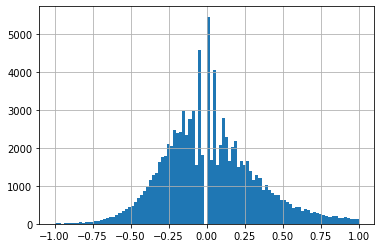

In [5]:
ret_y_series = np.exp(y_series) - 1 # 获得回报的原始收益
ret_y_series.hist(range=(-1,1), bins=100)

In [6]:
ret_y_series.describe()

count    99419.000000
mean         0.116054
std          3.241139
min         -0.999923
25%         -0.183089
50%          0.000000
75%          0.229571
max        355.517368
Name: Y_logret, dtype: float64

In [7]:
ret_y_series.quantile(q=0.6)

0.08375886505374186

In [8]:
# 给ret分类
def label_ret(ret):
    '''
    class 0 = [-inf, -0.1]
    class 1 = [-0.1, 0.1] unprofitable
    class 2 = [0.1, inf]
    '''
    label = None
    if ret < -0.1:
        label = 0
    elif -0.1 <= ret and ret <= 0.1:
        label = 1
    else:
        label = 2
        
    return label
        
def label_ret_bi(ret):
    label = None
    if ret <= 0:
        label = 0
    else:
        label = 1
    return label        

In [17]:
label_y_series = ret_y_series.transform(label_ret_bi).rename('Y_label')
label_y_series.head()

start_time
2015-04-29 13:45:42.500    0
2015-04-29 13:46:23.500    0
2015-04-29 13:47:33.000    0
2015-04-29 13:48:47.500    0
2015-04-29 13:51:33.500    0
Name: Y_label, dtype: int64

In [18]:
ret_label_df = pd.concat([ret_y_series, label_y_series], axis=1)
ret_label_df.head()

,Y_logret,Y_label
start_time,,
2015-04-29 13:45:42.500,-0.041189,0
2015-04-29 13:46:23.500,-0.189663,0
2015-04-29 13:47:33.000,-0.154882,0
2015-04-29 13:48:47.500,-0.223081,0
2015-04-29 13:51:33.500,-0.189806,0


In [37]:
df = factor_df.join(label_y_series)
df = df.dropna()
factor_df = df[factor_df.columns]
label_y_series = df[label_y_series.name]

In [39]:
(factor_df.index == label_y_series.index).all()

True

In [40]:
factor_train, factor_test, y_train, y_test = train_test_split(factor_df, label_y_series, test_size=0.25, shuffle=False)


In [41]:
NUM_CLASSES = 2
y_train_cat = keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_test_cat = keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

In [27]:
y_test_cat

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [42]:
def set_gpu_option():
    os.environ["CUDA_VISIBLE_DEVICES"]="1" 
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    keras.backend.tensorflow_backend.set_session(sess)
    
def create_model(in_shape, num_classes):
    NUM_NEURONS = 16
    model = Sequential()
    model.add(Dense(NUM_NEURONS, input_shape=input_shape, activation='relu'))
    model.add(Dense(NUM_NEURONS, activation='relu'))
    model.add(Dense(NUM_NEURONS, activation='relu'))
    model.add(Dense(NUM_NEURONS, activation='relu'))


    model.add(Dense(num_classes, activation='softmax'))  
    model.summary()
    
    return model

In [29]:
y_train

start_time
2015-04-29 13:45:42.500    0
2015-04-29 13:46:23.500    0
2015-04-29 13:47:33.000    0
2015-04-29 13:48:47.500    0
2015-04-29 13:51:33.500    0
                          ..
2017-06-26 09:11:43.500    1
2017-06-26 09:13:58.500    1
2017-06-26 09:16:09.500    1
2017-06-26 09:17:43.500    1
2017-06-26 09:21:28.000    1
Name: Y_label, Length: 74564, dtype: int64

In [43]:
from keras import backend as K
def Precision(y_true, y_pred):
    """精确率"""
    tp= K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # true positives
    pp= K.sum(K.round(K.clip(y_pred, 0, 1))) # predicted positives
    precision = tp/ (pp+ K.epsilon())
    return precision
    
def Recall(y_true, y_pred):
    """召回率"""
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # true positives
    pp = K.sum(K.round(K.clip(y_true, 0, 1))) # possible positives
    recall = tp / (pp + K.epsilon())
    return recall
 
def F1(y_true, y_pred):
    """F1-score"""
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1    


In [44]:
input_shape = (factor_df.shape[1],)
NUM_CLASSES = 2
model = create_model(in_shape=input_shape, num_classes=NUM_CLASSES)
set_gpu_option()
model.compile(optimizer=Adam(lr=1e-6),loss='categorical_crossentropy', metrics=['accuracy', Precision, Recall, F1])
          

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 16)                2832      
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 34        
Total params: 3,682
Trainable params: 3,682
Non-trainable params: 0
_________________________________________________________________


In [31]:
y_train_cat

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [45]:
model.fit(x=factor_train, y=y_train_cat, epochs=100, verbose=1, validation_split=0.1, shuffle=False)


Train on 67095 samples, validate on 7456 samples
Epoch 1/100
67095/67095 [==============================] - 11s 161us/step - loss: 23.9310 - accuracy: 0.4876 - Precision: 0.4876 - Recall: 0.4876 - F1: 0.4876 - val_loss: 17.9568 - val_accuracy: 0.5058 - val_Precision: 0.5058 - val_Recall: 0.5058 - val_F1: 0.5058
Epoch 2/100
67095/67095 [==============================] - 11s 159us/step - loss: 20.3078 - accuracy: 0.4891 - Precision: 0.4890 - Recall: 0.4890 - F1: 0.4890 - val_loss: 13.7089 - val_accuracy: 0.5004 - val_Precision: 0.5004 - val_Recall: 0.5004 - val_F1: 0.5004
Epoch 3/100
67095/67095 [==============================] - 11s 159us/step - loss: 17.0994 - accuracy: 0.4887 - Precision: 0.4887 - Recall: 0.4887 - F1: 0.4887 - val_loss: 9.8438 - val_accuracy: 0.5031 - val_Precision: 0.5031 - val_Recall: 0.5031 - val_F1: 0.5031
Epoch 4/100
67095/67095 [==============================] - 11s 159us/step - loss: 14.6171 - accuracy: 0.4917 - Precision: 0.4917 - Recall: 0.4917 - F1: 0.4917 -

In [34]:
model.evaluate(x=factor_test, y=y_test_cat)


24855/24855 [==============================] - 1s 44us/step


[1.082537906598191, 0.39372360706329346]

In [35]:
predict_y_test = model.predict(x=factor_test)
predict_y_test

array([[0.35685503, 0.27239168, 0.37075332],
       [0.35685503, 0.27239168, 0.37075332],
       [0.35685503, 0.27239168, 0.37075332],
       ...,
       [0.35685503, 0.27239168, 0.37075332],
       [0.35685503, 0.27239168, 0.37075332],
       [0.35685503, 0.27239168, 0.37075332]], dtype=float32)

In [68]:
predict_y_test_series = pd.Series(data=predict_y_test.flatten(), index=y_test.index, name='predict_y_test')
predict_y_test_series

ValueError: Length of passed values is 74565, index implies 24855